# Quantum Autoencoder: Personal Project

In this project, I aim to build a Quantum Autoencoder—a quantum circuit designed to compress quantum states onto fewer qubits while preserving the essential information from the original state.

I'll explore the architecture of a Quantum Autoencoder, detailing how to design and train it for efficient compression and encoding. To showcase its capabilities, I'll provide two examples: one demonstrating compression of various quantum states, and another focusing on compressing images of zeros and ones.


1. What is an Autoencoder?

For my project, I’m focusing on autoencoders—a type of neural network architecture designed to learn efficient ways to compress and encode information from input data. The main idea is to use representation learning to capture the most important features, compressing the data into a smaller form. Later, a decoder can reconstruct the original data from this compressed representation.

Autoencoders are typically organized into three main layers:
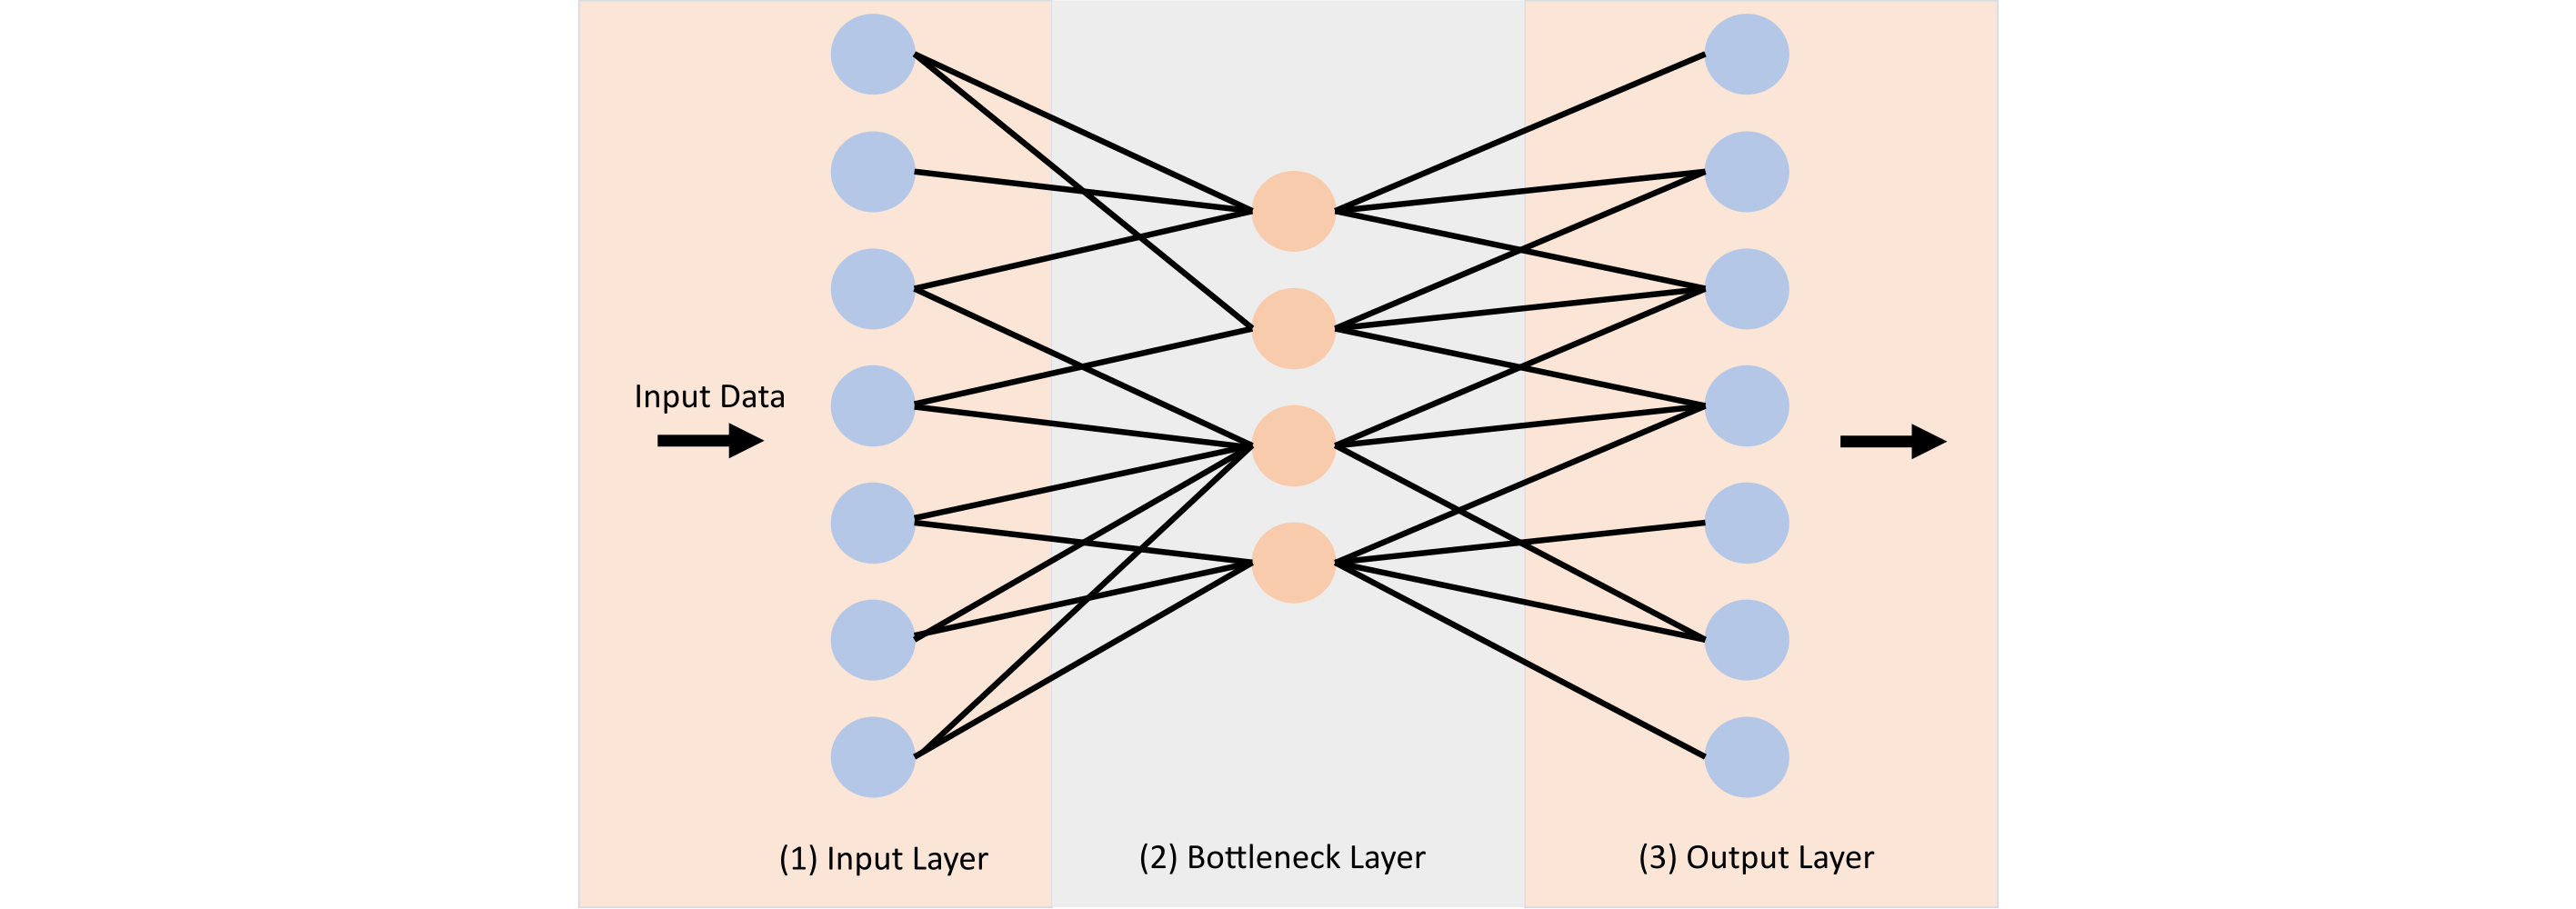

In my project, I start with the Input Layer (1), where I feed in data of length \( n \). This data then moves through an encoder, reaching the Bottleneck Layer (2), which has fewer nodes or reduced dimensions—effectively compressing the input. My autoencoder may include several layers in this encoding process.

Next, the compressed data is passed to the Output Layer (3), where a decoder reconstructs the data back to its original size from the compressed representation.

By running my data through this autoencoder, I can reduce its dimensionality at the bottleneck layer while preserving as much essential information as possible. This approach is useful for tasks like image denoising, anomaly detection, and facial recognition, and I’ll be exploring these capabilities in my quantum autoencoder implementation.

## 2. The Quantum Autoencoder

For my project, I'm defining a quantum counterpart to the classical autoencoder (CAE), which I call the Quantum Autoencoder. Much like the CAE, the Quantum Autoencoder aims to reduce the dimensionality of the input, which in this case is a quantum state. A visual representation of this concept is shown in Figure 2.

![Diagram of a Quantum Autoencoder showing Input Layer (1) with input state |ψ_input⟩, an Encoder block leading to a Bottleneck Layer (2) with state |ψ_COMP⟩ and several |0⟩ states, a Decoder block leading to an Output Layer (3) with reconstructed state |ψ_Recon⟩]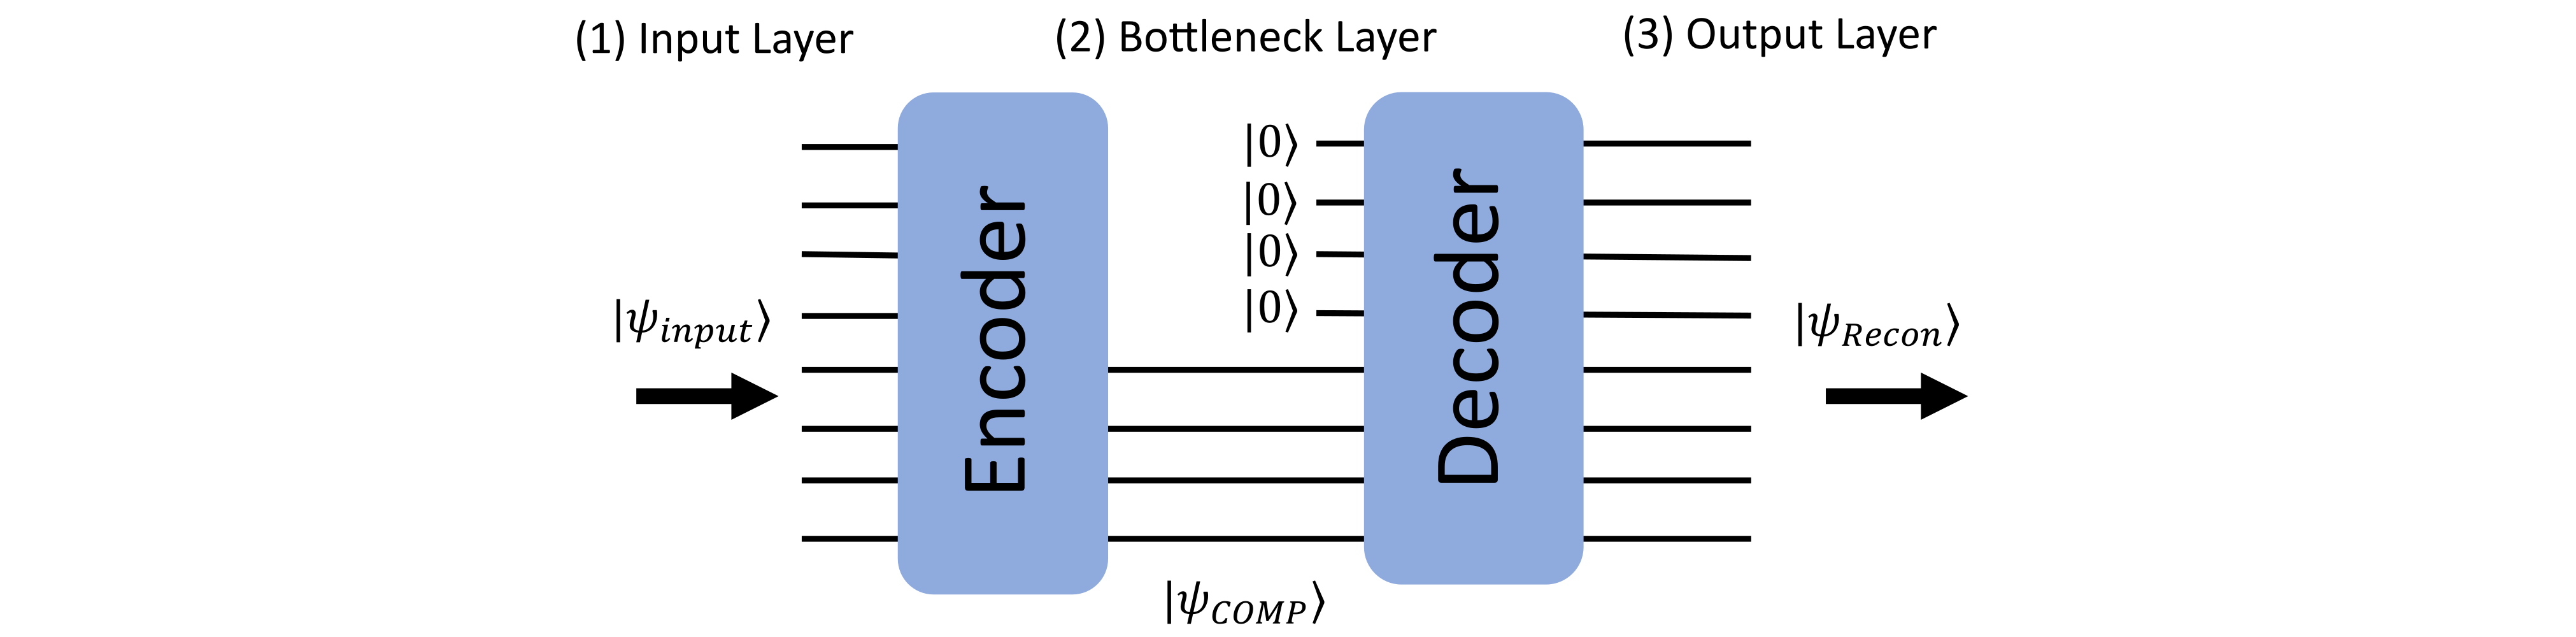

**Figure 2:** Pictorial Representation of a Quantum Autoencoder. Here one can see the similarities with the CAE, with the circuit having an input state, bottleneck state and an output state.

Much like its classical counterpart, my quantum circuit contains three layers. First, I input our state \( |\psi_{input}\rangle \) (which contains \( n \) qubits), which I wish to compress. This is my input layer (1).

Then I apply our parameterized circuit on our input state, which will act as our encoder and 'compresses' our quantum state, reducing the dimensionality of our state to \( n - k \) qubits. Our new compressed state is of the form \( |\psi_{comp}\rangle \otimes |0\rangle^{\otimes k} \), where \( |\psi_{comp}\rangle \) contains \( n - k \) qubits.

This parameterized circuit depends on a set of parameters, which are the nodes of the Quantum Autoencoder. Throughout the training process, these parameters will be updated to optimize the loss function.

I will disregard the remaining k qubits for the remaining of the circuit. This is the bottleneck layer (2) and the input state is now compressed.

The final layer consists of the addition of k qubits (all in the state |0⟩) and applying another parameterized circuit between the compressed state and the new qubits. The parameterized circuit acts as my decoder and reconstructs the input stage from the compressed state using the new qubits. After the decoder, the original state is retained as the state travels to the output layer.

### 3. Components of My Quantum Autoencoder

Before I start building my Quantum Autoencoder, there are a few important details to consider.

One key point is that, when using Qiskit, I can't simply add or remove qubits in the middle of a quantum circuit. This means I need to plan ahead and include all the necessary qubits—such as the reference state and any auxiliary qubits—right from the start.

So, my input state will include not only the data I want to compress, but also the reference state and an auxiliary qubit. I'll also add a classical register for measurements, which I'll explain in the next section. Figure 3 provides a visual overview of this setup.

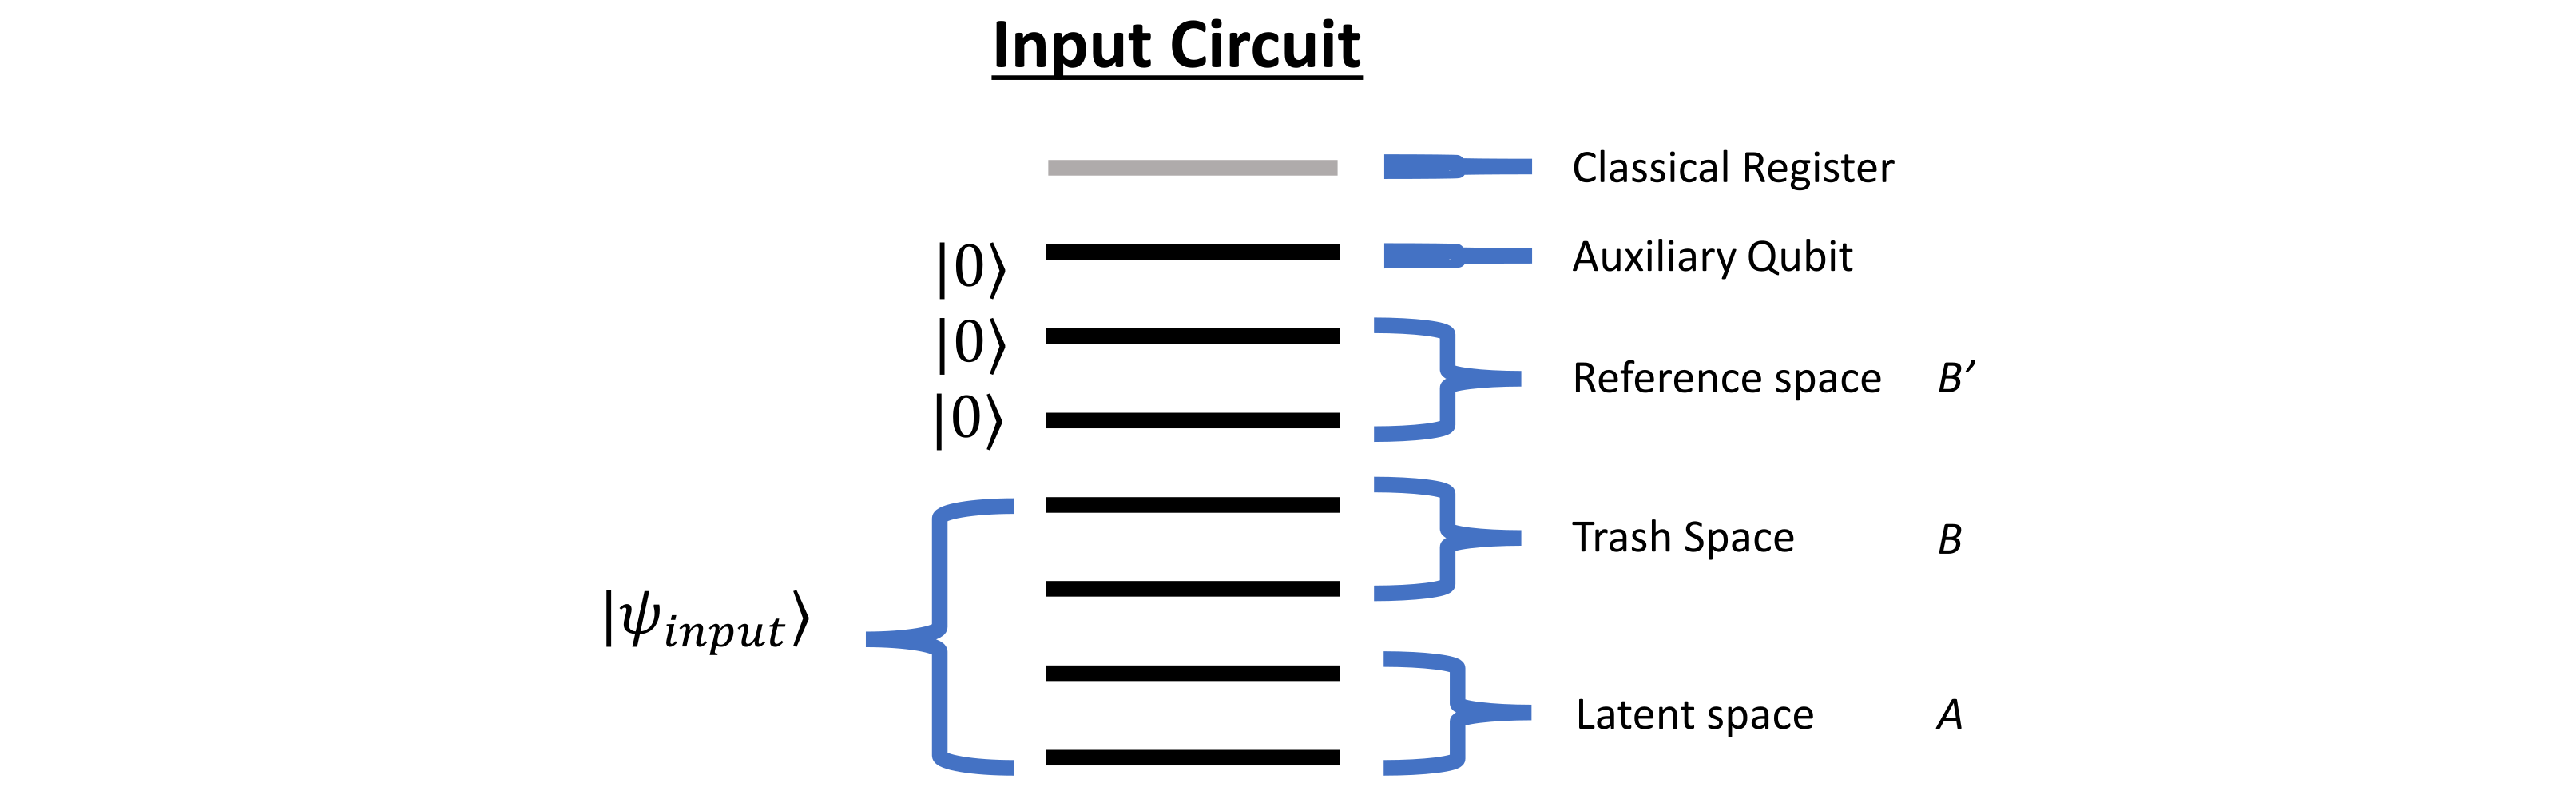

5 Building the Quantum Autoencoder Ansatz

In [7]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42
sampler = Sampler()

In [8]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

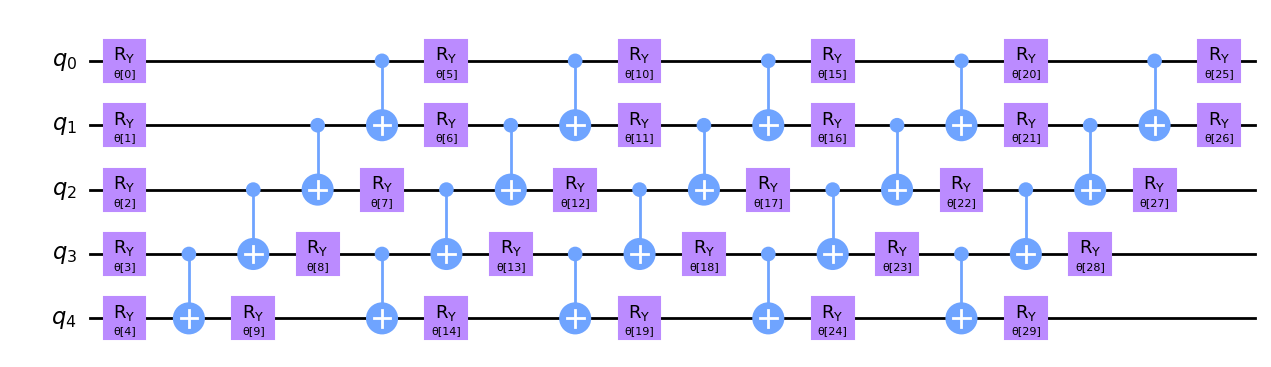

In [9]:
num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw(output='mpl', style='clifford')

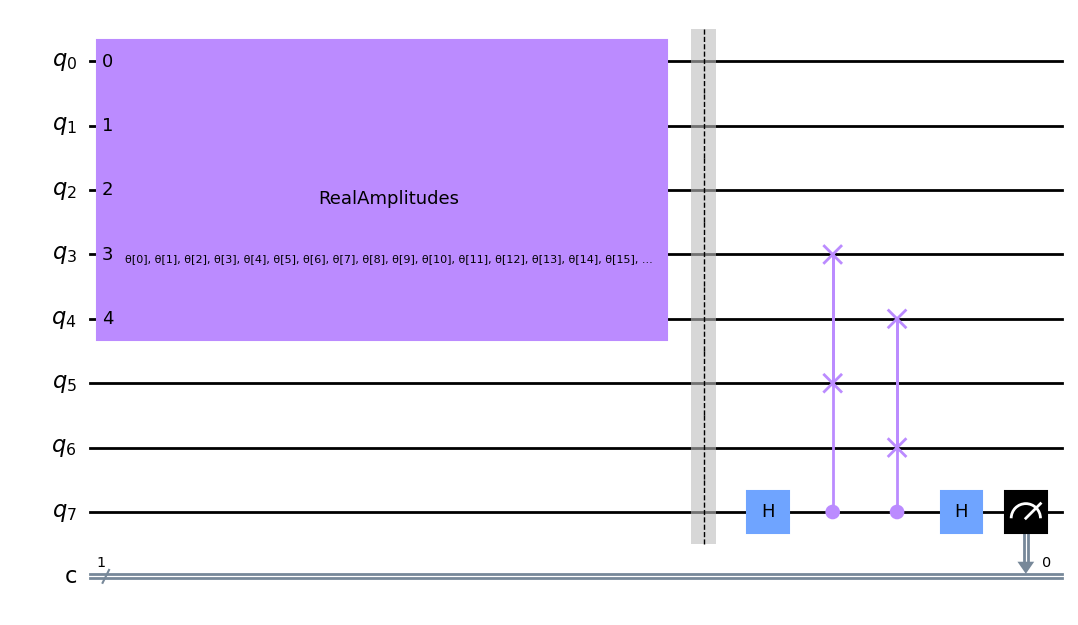

In [10]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")

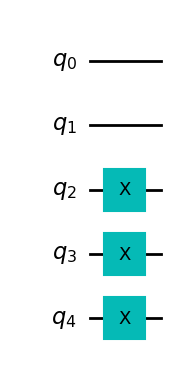

In [11]:
def domain_wall(circuit, a, b):
    # Here we place the Domain Wall to qubits a - b in our circuit
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit


domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl", style="clifford")

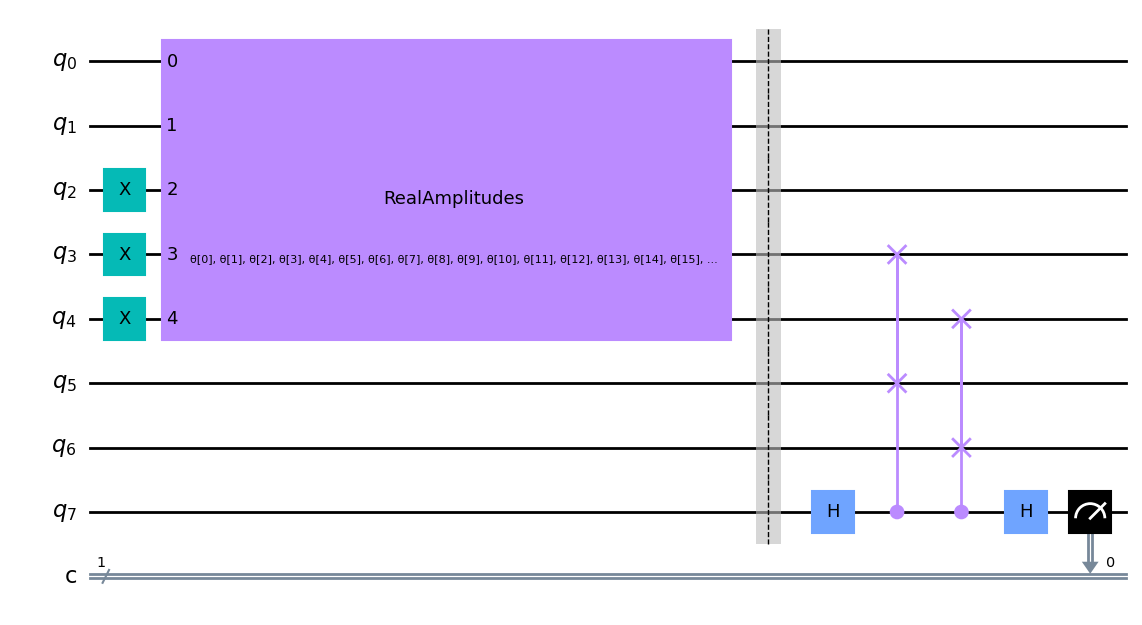

In [12]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw(output="mpl", style="clifford")

In [13]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [14]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

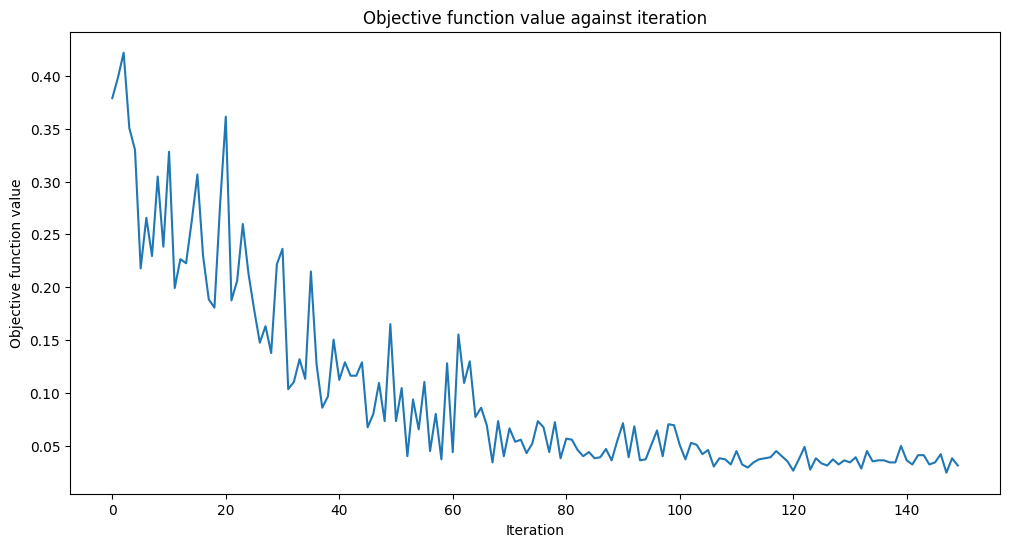

Fit in 9.52 seconds


In [15]:
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

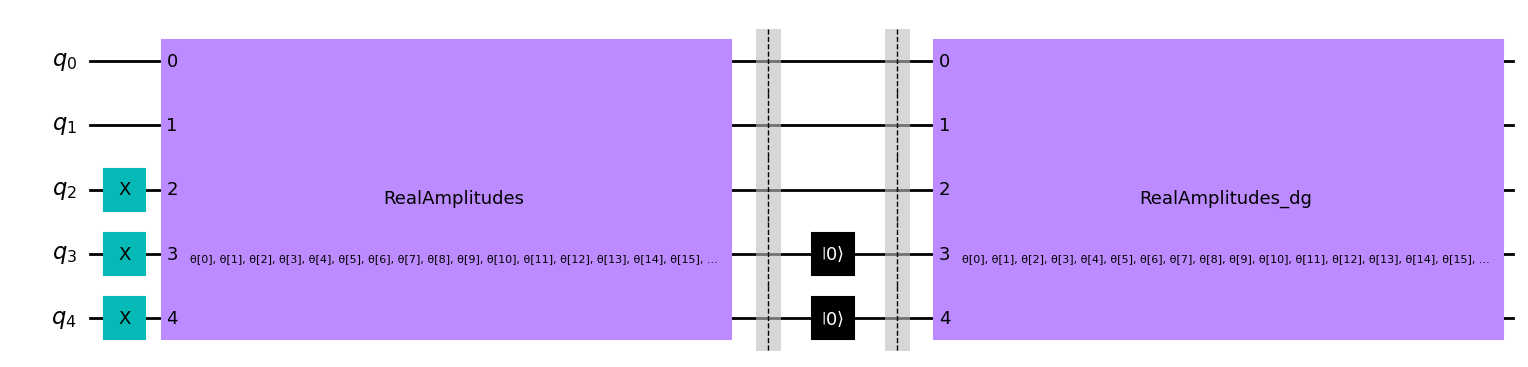

In [16]:
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(domain_wall_circuit)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw(output="mpl", style="clifford")

In [17]:
test_qc = test_qc.assign_parameters(opt_result.x)

In [18]:
domain_wall_state = Statevector(domain_wall_circuit).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(domain_wall_state.conj(), output_state) ** 2)
print("Fidelity of our Output State with our Input State: ", fidelity.real)

Fidelity of our Output State with our Input State:  0.9651458833977725


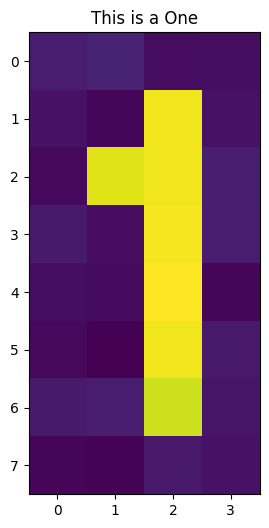

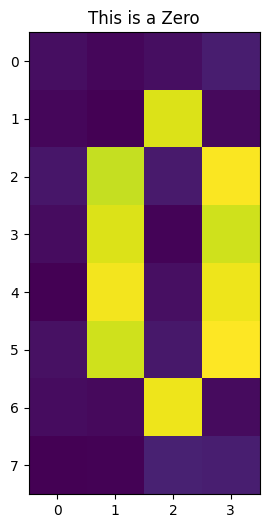

In [19]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = algorithm_globals.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = algorithm_globals.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(2)

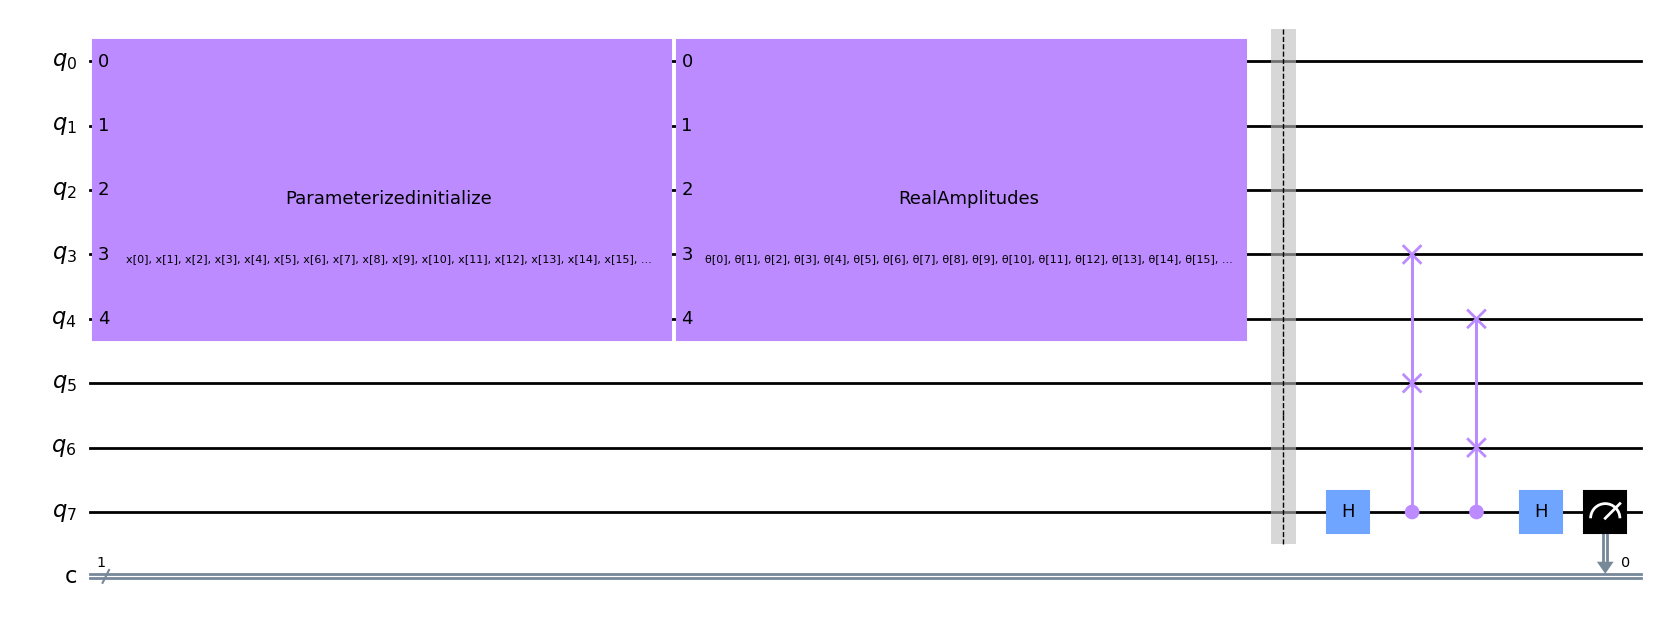

In [20]:
num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw(output="mpl", style="clifford")

In [21]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [22]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

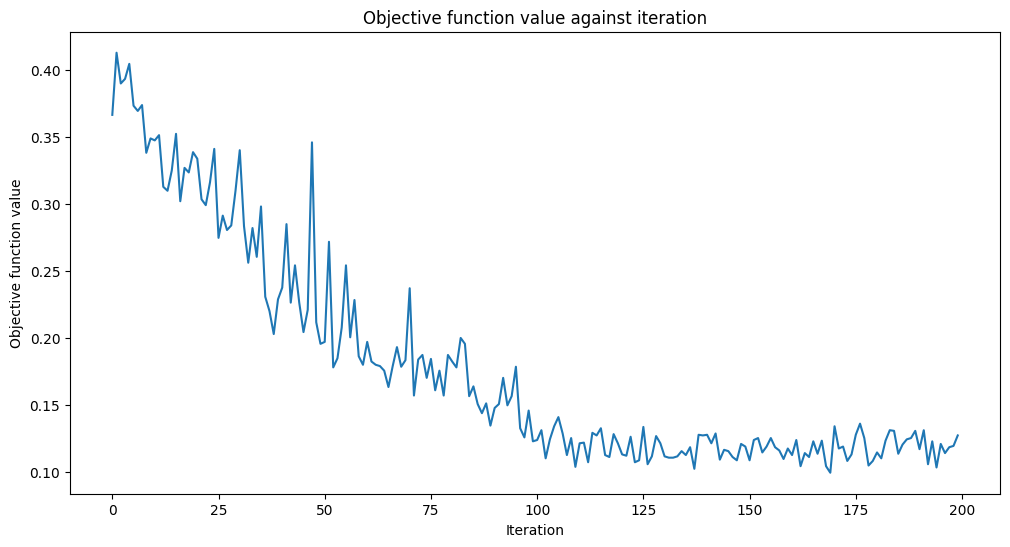

Fit in 13.15 seconds


In [26]:
opt = COBYLA(maxiter=200)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

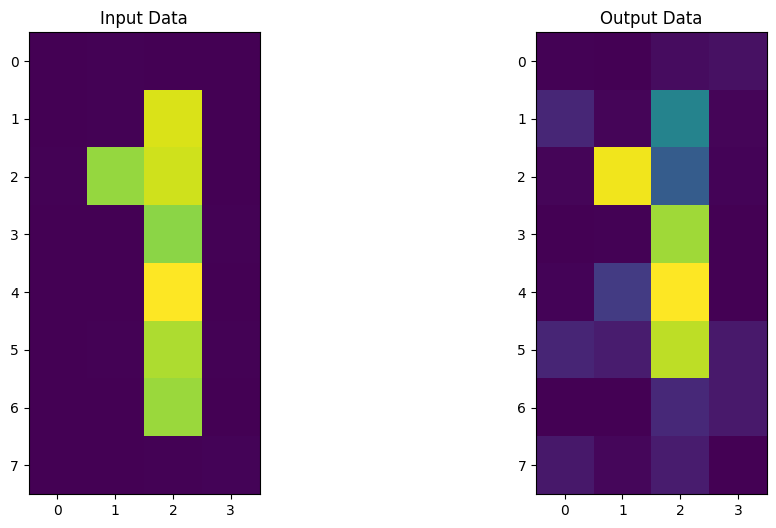

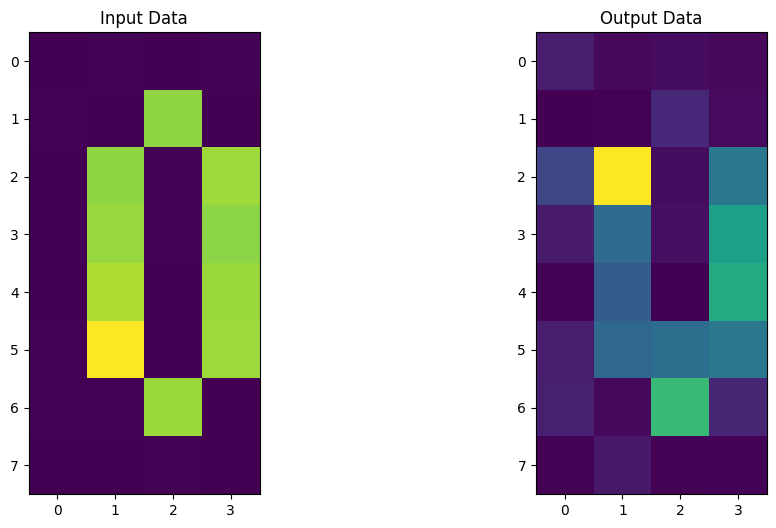

In [27]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()